In [1]:
# general
import warnings
from tqdm import tqdm
from datasets import load_dataset, Dataset as DS
import time
from collections import defaultdict
from transforms.PermuteImage import PermuteImage
from os.path import isfile
from Utils.Utilities import *

# ML
import numpy as np
import pandas as pd

# visual
import matplotlib.pyplot as plt
import seaborn as sns

# # DL
import torch
from torch.nn import Module
import cv2
from torch import nn, Tensor
from torch.utils.data import DataLoader, SubsetRandomSampler, Dataset
from torchvision import transforms, models
from modules.HeadlessPretrainedModule import HeadlessPretrainedModule
from modules.CustomModule import CustomModule
from modules.CustomModule import CustomModule2
from transforms.Transform_Builder import Transform_Builder
from modules.VitModule import VitModule

warnings.filterwarnings('ignore')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
SEED = 42

## Load the dataset

In [2]:
dataset = load_dataset("cats_vs_dogs", trust_remote_code=True, verification_mode='no_checks')
dataset = dataset['train']

In [3]:
splitted_dataset = dataset.train_test_split(test_size=0.05, shuffle=True, seed=SEED)
train_val_dataset = splitted_dataset['train'].train_test_split(test_size=0.05, shuffle=True, seed=SEED)

In [4]:
train = train_val_dataset['train']
val = train_val_dataset['test']
test = splitted_dataset['test']

In [16]:
def transform_datasets(datasets: tuple[Dataset], transform = callable):
    return (dataset.with_transform(transform) for dataset in datasets)

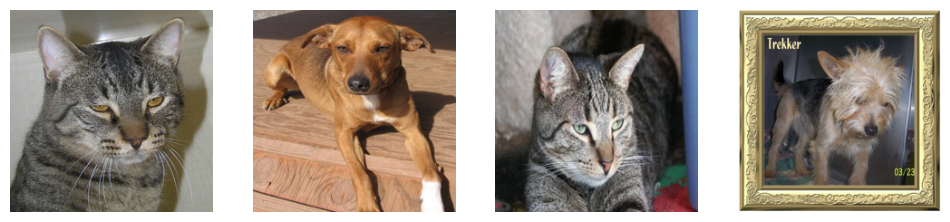

In [5]:
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
for i in range(4):
    img = train[i]['image'].resize((224,224))
    axes[i].imshow(img)
    axes[i].axis('off')
plt.show()

#### 1. Pretrained model baseline

In [6]:
pretrained_transform = Transform_Builder.build(size=224)
train_set, val_set, test_set = Transform_Builder.transform_datasets((train, val, test), transform=pretrained_transform)

In [7]:
dataloaders = {
    'train': DataLoader(train_set, batch_size=32, drop_last=True, shuffle=True, num_workers=0),
    'val': DataLoader(val_set, batch_size=32, drop_last=True, num_workers=0),
    'test': DataLoader(test_set, batch_size=32, drop_last=True, num_workers=0),
}

In [8]:
pretrained_model = HeadlessPretrainedModule(pretrained_model = models.resnet50(pretrained=True), device=device)
pretrained_model = pretrained_model.to(device)

In [9]:
if isfile("./pretrained_model.pth"):
    pretrained_model.load_state_dict(torch.load("./pretrained_model.pth"))
else:
    lr = 5e-3
    num_epochs = 5

    optimizer = torch.optim.SGD(pretrained_model.parameters(), lr, momentum=0.9)
    criterion = nn.CrossEntropyLoss()
    pretrained_model.start_train(criterion, optimizer, dataloaders)
    torch.save(pretrained_model.state_dict(), "./pretrained_model.pth")

In [10]:
pretrained_model.predict_data(dataloaders['test'])

Test Acc: 0.987800


##### 1.2 Evaluating premuted images

In [13]:
tiles_num_options = [4,9,16,25,36]

In [30]:
def run_verious_tile_test(model : Module, tiles_num_options: list, is_vit=False, processor = None, size:int =224):
    results = {"Tiles": [], "Accuracy": []}
    for tiles_num in tiles_num_options:
        transform_with_premute = Transform_Builder.build(size=size, with_premute=True, tiles_num=tiles_num, is_vit=is_vit, processor=processor)
        premuted_test_set = test.with_transform(transform_with_premute)
        premuted_dataloader = DataLoader(premuted_test_set, batch_size=32, drop_last=True, num_workers=0)
        model.predict_data(premuted_dataloader)
        results["Tiles"].append(tiles_num)
        results["Accuracy"].append(model.test_acc)
    return results

In [14]:
pretrained_results = run_verious_tile_test(model = pretrained_model, tiles_num_options=tiles_num_options, size=224)

Test Acc: 0.961800
Test Acc: 0.935800
Test Acc: 0.877600
Test Acc: 0.797700
Test Acc: 0.713500


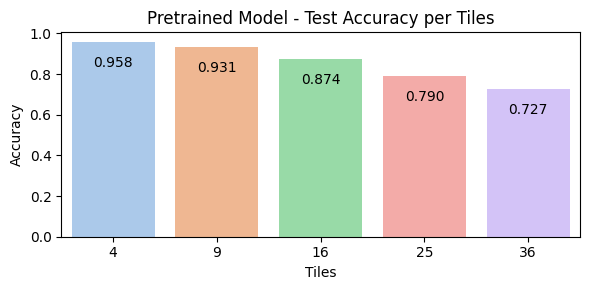

In [27]:
draw_bar_plot(data= pd.DataFrame(pretrained_results), y='Accuracy', x='Tiles', title='Pretrained Model - Test Accuracy per Tiles')

#### 2. Custom model baseline

In [16]:
custom_transform = Transform_Builder.build(size=100)
train_set, val_set, test_set = Transform_Builder.transform_datasets((train, val, test), transform=custom_transform)
custom_dataloaders = {
    'train': DataLoader(train_set, batch_size=32, drop_last=True, shuffle=True, num_workers=0),
    'val': DataLoader(val_set, batch_size=32, drop_last=True, num_workers=0),
    'test': DataLoader(test_set, batch_size=32, drop_last=True, num_workers=0),
}

In [17]:
custom_model = CustomModule2(device=device)
custom_model = custom_model.to(device)

In [18]:
if isfile("./CustomModel.pth"):
    custom_model.load_state_dict(torch.load("./CustomModel.pth"))
else:
    lr = 1e-3
    num_epochs = 30

    optimizer = torch.optim.Adam(custom_model.parameters(), lr)
    criterion = nn.CrossEntropyLoss()
    custom_model.start_train(criterion, optimizer, dataloaders, num_epochs=num_epochs)
    torch.save(custom_model.state_dict(), "./CustomModel.pth")

In [19]:
custom_model.predict_data(custom_dataloaders['test'])

Test Acc: 0.978300


##### 2.2 Evaluating premuted images

In [30]:
custom_results = run_verious_tile_test(model = custom_model, tiles_num_options=tiles_num_options, size=100)

Test Acc: 0.647600
Test Acc: 0.620700
Test Acc: 0.611100
Test Acc: 0.599000
Test Acc: 0.559900


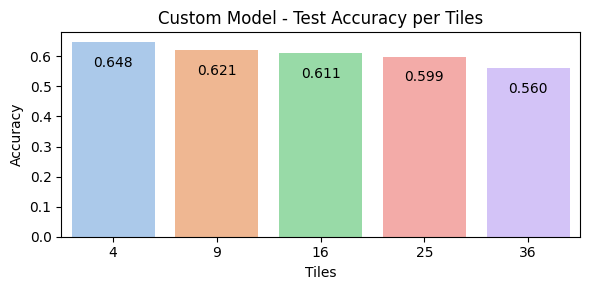

In [31]:
draw_bar_plot(data= pd.DataFrame(custom_results), y='Accuracy', x='Tiles', title='Custom Model - Test Accuracy per Tiles')

##### 2.3 Getting correctly predicted Images out of test set

In [53]:
test_images = splitted_dataset['test']['image']
tp_test_images = [test_images[i] for i in torch.argwhere(match)]

In [171]:
test_labels = splitted_dataset['test']['labels']
tp_test_labels = [test_labels[i] for i in torch.argwhere(match)]


In [185]:
from datasets import Dataset

dataset2 = Dataset.from_dict({'image': test_images, 'labels': test_labels})

#### 3. Vit Model Baseline

In [20]:
Vit_model = VitModule('nateraw/vit-base-cats-vs-dogs', device)

In [21]:
test_set = test.with_transform(Transform_Builder.build(is_vit=True, processor=Vit_model.processor))
test_loader = DataLoader(test_set, batch_size=32, drop_last=True, num_workers=0)

In [22]:
Vit_model.predict_data(test_loader)

Test Acc: 0.997400


In [23]:
vit_results = {"Tiles": [], "Accuracy": []}
for tiles_num in tiles_num_options:
    vit_transform_with_premute = Transform_Builder.build(tiles_num=tiles_num, is_vit=True, processor=Vit_model.processor)
    vit_premuted_test_set = test.with_transform(vit_transform_with_premute)
    vit_premuted_dataloader = DataLoader(vit_premuted_test_set, batch_size=32, drop_last=True, num_workers=0)
    Vit_model.predict_data(vit_premuted_dataloader)
    vit_results["Tiles"].append(tiles_num)
    vit_results["Accuracy"].append(Vit_model.test_acc)

Test Acc: 0.997400
Test Acc: 0.997400
Test Acc: 0.997400
Test Acc: 0.997400
Test Acc: 0.997400


In [31]:
vit_results = run_verious_tile_test(tiles_num_options=tiles_num_options, model=Vit_model, is_vit=True, processor = Vit_model.processor)

Test Acc: 0.995700
Test Acc: 0.993100
Test Acc: 0.974800
Test Acc: 0.960900
Test Acc: 0.952300


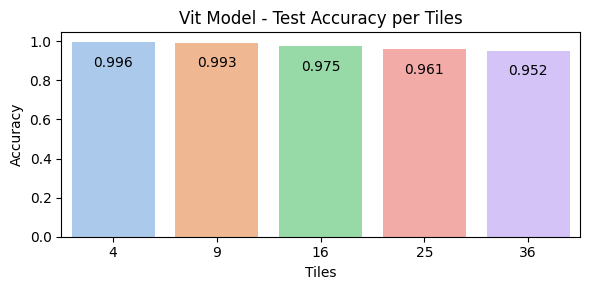

In [32]:
draw_bar_plot(data= pd.DataFrame(vit_results), y='Accuracy', x='Tiles', title='Vit Model - Test Accuracy per Tiles')

### Permutation Ranking

In [37]:
tiles_num = 9
permutation_dict = create_premutation(tiles_num)

In [38]:
permuted_test_set = test.with_transform(Transform_Builder.build(224, with_premute=True, tiles_num=tiles_num, permutations_set= list(permutation_dict.values())))

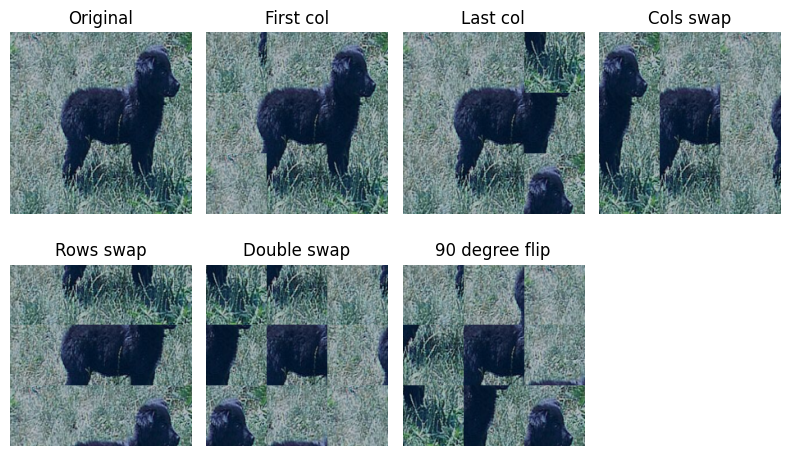

In [39]:
draw_images(permuted_test_set[0]['image'], permutation_dict.keys())

In [41]:
def run_tile_rank_test(model : Module, permutation_dict: dict, base_score, is_vit=False, processor = None, size:int =224):
        results = {'Score': [], 'Accuracy': []}
        for premutation in permutation_dict.values():
                permuted_test_set = test.with_transform(Transform_Builder.build(size=size, with_premute=True, tiles_num=len(premutation), permutations_set= [premutation], is_vit=is_vit, processor=processor))
                dataloader = DataLoader(permuted_test_set, batch_size=32, drop_last=True, num_workers=0)
                results['Score'].append(np.abs(calculate_tiles_derivative(permuted_test_set[:]['image'])-base_score)/len(permuted_test_set))
                model.predict_data(dataloader)
                results['Accuracy'].append(model.test_acc)
        return results

In [45]:
def draw_rank_test_results(results, permutation_dict, model_name):
    df= pd.DataFrame(results)
    df['Permutation'] = permutation_dict.keys()
    df['Permutations Rank'] = df.Score.rank() -1
    sns.lineplot(data= df, y='Accuracy', x='Permutations Rank')
    for i, row in df.iterrows():
        plt.scatter( y=row.Accuracy, x=row['Permutations Rank'], label=row.Permutation)
    plt.legend()
    plt.title(f'{model_name} - Accuracy Vs Permutation Rank')
    plt.show();

#### Custom model

In [12]:
test_set = test.with_transform(Transform_Builder.build(100))
base_score = calculate_tiles_derivative(test_set[:]['image'])

In [13]:
custom_results = run_tile_rank_test(custom_model, permutation_dict, 100, base_score)

Test Acc: 0.972200
Test Acc: 0.918400
Test Acc: 0.917500
Test Acc: 0.803000
Test Acc: 0.734400
Test Acc: 0.660600
Test Acc: 0.666700


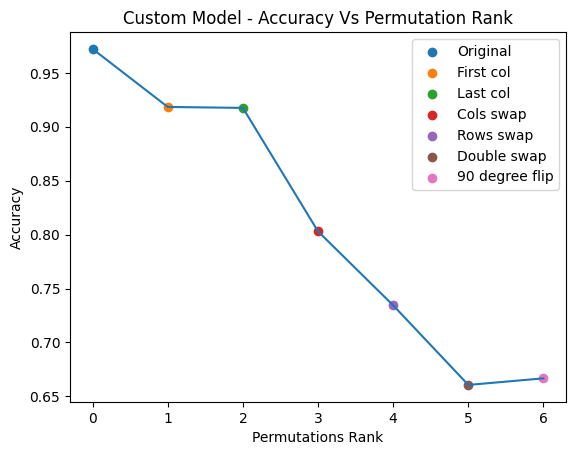

In [37]:
draw_rank_test_results(custom_results, permutation_dict, "Custom Model")

#### Pretrained Model

In [35]:
test_set = test.with_transform(Transform_Builder.build(224))
base_score = calculate_tiles_derivative(test_set[:]['image'])

In [43]:
pretrained_results = run_tile_rank_test(model=pretrained_model, permutation_dict=permutation_dict, base_score=base_score, size=224)

Test Acc: 0.987800
Test Acc: 0.981800
Test Acc: 0.980900
Test Acc: 0.969600
Test Acc: 0.954900
Test Acc: 0.932300
Test Acc: 0.906200


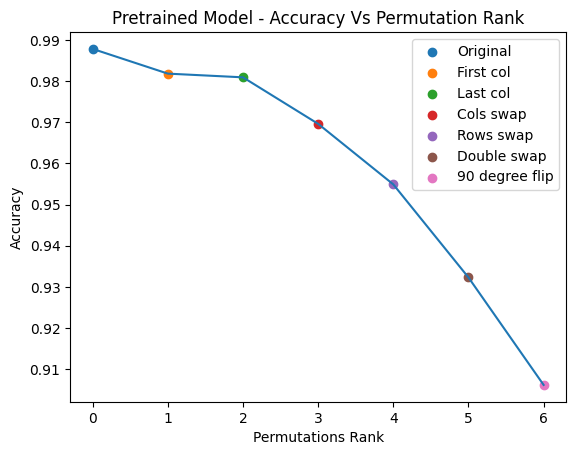

In [46]:
draw_rank_test_results(pretrained_results, permutation_dict, 'Pretrained Model')

#### Vit Model

In [47]:
test_set = test.with_transform(Transform_Builder.build(is_vit=True, processor=Vit_model.processor))
base_score = calculate_tiles_derivative(test_set[:]['image'])

In [48]:
Vit_results = run_tile_rank_test(model=Vit_model, permutation_dict=permutation_dict, base_score = base_score, is_vit=True, processor=Vit_model.processor)

Test Acc: 0.997400
Test Acc: 0.997400
Test Acc: 0.997400
Test Acc: 0.997400
Test Acc: 0.995700
Test Acc: 0.990500
Test Acc: 0.982600


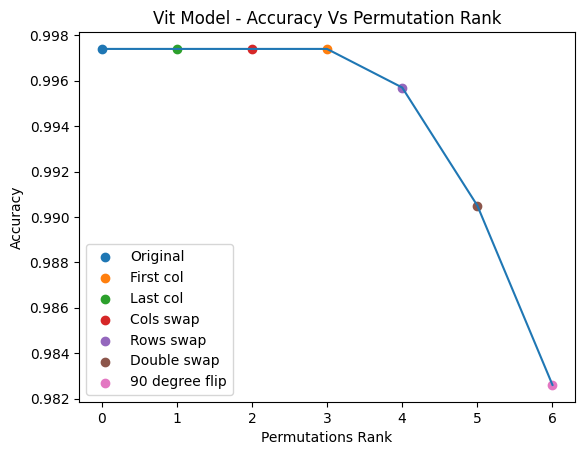

In [50]:
draw_rank_test_results(Vit_results, permutation_dict, 'Vit Model')

### stuff

In [ ]:
Vit_model.processor(test[:3]["image"], return_tensors='pt')['pixel_values'].shape

In [12]:
for i, img in enumerate(train[:]["image"]):
    if img.mode != 'RGB':
        print(i)
        break

599


In [7]:
test_set = test.with_transform(Transform_Builder.build_vit_transform(Vit_model.processor))

In [82]:
test_set = test.with_transform(vit_transform)

In [8]:
test_set[0]['image'].shape

torch.Size([3, 224, 224])

In [125]:
def build_transform_with_premute(tiles_num= 4, permutations_set=None):

    def transform(example_batch):
        lst = []
        if example_batch.get('image'):
            for img in example_batch['image']:
                if img.mode != 'RGB':
                    img = img.convert('RGB')
                img = Vit_model.processor(img, return_tensors='pt')['pixel_values']
                img = PermuteImage(tiles_num, permutations_set)(img.squeeze(0))
                lst.append(img)
        # Take a list of PIL images and turn them to pixel values
        example_batch['image'] = torch.stack(lst)

        # Don't forget to include the labels!
        example_batch['labels'] = torch.tensor(example_batch['labels'], dtype=torch.int64) 
        return example_batch
    return transform

In [10]:
def create_premutation(tiles_num: int) -> dict:
    permutation_dict = {}
    tiles_per_row = int(np.sqrt(tiles_num))
    tiles_arr = np.arange(tiles_num).reshape(tiles_per_row,tiles_per_row)
    permutation_dict["Original"]  = list(np.arange(tiles_num))
    permutation_dict["First col"]  = list(np.hstack([tiles_arr[:,0][::-1].reshape(-1,1), tiles_arr[:,1:]]).flatten())
    permutation_dict["Last col"]  = list(np.hstack([tiles_arr[:,:-1],tiles_arr[:,-1][::-1].reshape(-1,1)]).flatten())
    permutation_dict["Middle cols"] = list(np.hstack([tiles_arr[:,0].reshape(-1,1),tiles_arr[:,1:-1][::-1],tiles_arr[:,-1].reshape(-1,1)]).flatten())
    permutation_dict["Cols swap"] = list(tiles_arr[:,np.arange(tiles_per_row)[::-1]].flatten())
    horizontal_swap = tiles_arr[np.arange(tiles_per_row)[::-1],:]
    permutation_dict["Rows swap"] = list(horizontal_swap.flatten())
    permutation_dict["Double swap"] = list(np.arange(tiles_num)[::-1])
    permutation_dict["90 degree flip"] = list(tiles_arr.T[:,np.arange(tiles_per_row)[::-1]].flatten())
    return permutation_dict
permutation_dict = create_premutation(tiles_num=9)

In [15]:
t = build_transform_with_premute(tiles_num=9, permutations_set= [permutation_dict['Double swap']])
# test_set = test.with_transform(t)
test_set= test.with_transform(t)

In [11]:
test_set = test.with_transform(Transform_Builder.build_transform_with_premute(Vit_model.processor, tiles_num=9, permutations_set= [permutation_dict['Double swap']]))

In [16]:
vit_premuted_dataloader = DataLoader(test_set, batch_size=32, drop_last=True, num_workers=0)
Vit_model.predict_data(vit_premuted_dataloader)

Test Acc: 0.990500


In [108]:
len(test_set[:320])

2